# Introduction
This notebook demonstrates basic usage of BioThings Explorer, an engine for autonomously querying a distributed knowledge graph. BioThings Explorer can answer two classes of queries -- "EXPLAIN" and "PREDICT".  EXPLAIN queries are described in [EXPLAIN_demo.ipynb](EXPLAIN_demo.ipynb). Here, we describe PREDICT queries and how to use BioThings Explorer to execute them.  A more detailed overview of the BioThings Explorer systems is provided in [these slides](https://docs.google.com/presentation/d/1QWQqqQhPD_pzKryh6Wijm4YQswv8pAjleVORCPyJyDE/edit?usp=sharing).

PREDICT queries are designed to **predict plausible relationships between one entity and an entity class**.  For example, in this notebook, we explore the question:

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;*"For a patient with disease X, what are some factors (such as genetic features, comorbidities, etc) that could cause sensitivity or resistance to drug Y? "* And we specifically use Breast Cancer as disease X for this use case demo.

**To experiment with an executable version of this notebook, [load it in Google Colaboratory](https://colab.research.google.com/github/biothings/biothings_explorer/tree/call-apis-new/jupyter%20notebooks/drug_response_predict.ipynb).**

## Step 0: Load BioThings Explorer modules
First, install the `biothings_explorer` and `data_tools` packages. This only needs to be done once (but including it here for compability with [colab](https://colab.research.google.com/)).

In [ ]:
!pip install git+https://github.com/biothings/biothings_explorer.git@call-apis-new
!pip install git+https://github.com/mmayers12/data_tools

Change the Width of Notebook

In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

Next, import the relevant modules:

* **Hint**: Find corresponding bio-entity representation used in BioThings Explorer based on user input (could be any database IDs, symbols, names)
* **Predict**: Find intermediate bio-entities which connects user specified input and output

In [2]:
from biothings_explorer.query.predict import Predict
from biothings_explorer.query.visualize import display_graph
from biothings_explorer.hint import Hint
import nest_asyncio
nest_asyncio.apply()
%matplotlib inline
import warnings
warnings.filterwarnings("ignore") 

/Users/kevinxin/Documents/work/biothings_explorer/bte_schema/ENV/lib/python3.7/site-packages/data_tools/df_processing.py:4: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


## Query Path: Disease -> Variant -> ChemicalSubstance/Drug

### Step 1: Find representation of "breast cancer" in BTE

In this step, BioThings Explorer translates our query string "breast cancer"  into BioThings objects, which contain mappings to many common identifiers.  Generally, the top result returned by the `Hint` module will be the correct item, but you should confirm that using the identifiers shown.

Search terms can correspond to any child of [BiologicalEntity](https://biolink.github.io/biolink-model/docs/BiologicalEntity.html) from the [Biolink Model](https://biolink.github.io/biolink-model/docs/), including `DiseaseOrPhenotypicFeature` (e.g., "lupus"), `ChemicalSubstance` (e.g., "acetaminophen"), `Gene` (e.g., "CDK2"), `BiologicalProcess` (e.g., "T cell differentiation"), and `Pathway` (e.g., "Citric acid cycle").

In [3]:
ht = Hint()
brca = ht.query("breast cancer")['Disease'][0]
brca

{'MONDO': 'MONDO:0007254',
 'DOID': 'DOID:1612',
 'name': 'breast cancer',
 'MESH': 'D001943',
 'primary': {'identifier': 'MONDO',
  'cls': 'Disease',
  'value': 'MONDO:0007254'},
 'display': 'MONDO(MONDO:0007254) DOID(DOID:1612) MESH(D001943) name(breast cancer)',
 'type': 'Disease'}

### Step 2: Find Chemicals of which the drug response is affected by variants related to Breast Cancer

In this section, we find all paths in the knowledge graph that connect breast cancer to any entity that is a chemical compound.  To do that, we will use `Predict`.  This class is a convenient wrapper around two advanced functions for **query path planning** and **query path execution**. More advanced features for both query path planning and query path execution are in development and will be documented in the coming months.

Here, we formulate a `Predict` query with **breast cancer** as the `input_ojb`, **ChemicalSubstance** as the `output_obj` (which corresponds to a Biolink Entity type).  We further specify with the `intermediate_nodes` parameter that we are looking for paths joining hyperphenylalaninemia and chemical compounds with *one* intermediate node that is a SequenceVariant. We are also specifically ask BTE to expand Breast Cancer to all its subtypes based on the hierarchical order defined in MONDO ontology.

In [4]:
pd = Predict(
    input_objs=[brca],
    intermediate_nodes =['SequenceVariant'], 
    output_types =['ChemicalSubstance'], 
    config={"expand": True}
)
pd.connect(verbose=True)


========== QUERY EXPANSION ==========

You have selected to expand your inputs.
102 unique bioentities have been found as subclass of your inputs.

========== QUERY PARAMETER SUMMARY ==========

Your query have 103 input nodes, including breast cancer,breast lobular carcinoma,progesterone-receptor positive breast cancer,progesterone-receptor negative breast cancer,Her2-receptor negative breast cancer .... And BTE will find paths that connect your input nodes to your output types ['ChemicalSubstance']. Paths will contain 1 intermediate nodes.

Intermediate node #1 will have these type constraints: SequenceVariant

========== Query # 1 ==========

==== Step #1: Query Path Planning ====

Input Types: Disease
Output Types: SequenceVariant
Predicates: None

BTE found 2 APIs

API 1. mydisease.info API (1 API calls)
API 2. MyVariant.info API (1 API calls)


==== Step #2: Query path execution ====

NOTE: API requests are dispatched in parallel, so the list of APIs below is ordered by query ti

### Step 3: Display and Filter results


1. Display provenance/evidence information in a pandas dataframe
2. Rank the results based on Evidence Level information provided by CiVIC through Service Provider KP

In [5]:
df = pd.display_table_view(extra_fields=["clinical_significance", "evidence_level"]).sort_values(by="pred2_evidence_level")
df

,input_id,input_label,input_type,pred1,pred1_source,pred1_api,pred1_publications,node1_id,node1_label,node1_type,...,pred2,pred2_source,pred2_api,pred2_publications,output_id,output_label,output_type,output_degree,pred2_clinical_significance,pred2_evidence_level
185,MONDO:0016419,hereditary breast carcinoma,Disease,related_to,disgenet,mydisease.info API,None,DBSNP:rs121913273,rs121913273,SequenceVariant,...,variant_affect_drug_response,civic,MyVariant.info API,None,CHEBI:31638,fulvestrant,ChemicalSubstance,None,Sensitivity/Response,A
184,MONDO:0016419,hereditary breast carcinoma,Disease,related_to,disgenet,mydisease.info API,None,DBSNP:rs121913273,rs121913273,SequenceVariant,...,variant_affect_drug_response,civic,MyVariant.info API,None,CHEBI:93752,ALPELISIB,ChemicalSubstance,None,Sensitivity/Response,A
159,MONDO:0016419,hereditary breast carcinoma,Disease,related_to,disgenet,mydisease.info API,None,DBSNP:rs121913273,rs121913273,SequenceVariant,...,variant_affect_drug_response,civic,MyVariant.info API,None,CHEBI:93752,ALPELISIB,ChemicalSubstance,None,Sensitivity/Response,A
160,MONDO:0016419,hereditary breast carcinoma,Disease,related_to,disgenet,mydisease.info API,None,DBSNP:rs121913273,rs121913273,SequenceVariant,...,variant_affect_drug_response,civic,MyVariant.info API,None,CHEBI:31638,fulvestrant,ChemicalSubstance,None,Sensitivity/Response,A
918,MONDO:0005494,triple-negative breast carcinoma,Disease,related_to,disgenet,mydisease.info API,PMID:25801246,DBSNP:rs1801133,rs1801133,SequenceVariant,...,variant_affect_drug_response,civic,MyVariant.info API,None,CHEBI:60761,5-fluorouracil,ChemicalSubstance,None,Sensitivity/Response,B
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
564,MONDO:0016419,hereditary breast carcinoma,Disease,related_to,disgenet,mydisease.info API,PMID:15520168,DBSNP:rs121913279,rs121913279,SequenceVariant,...,variant_affect_drug_response,civic,MyVariant.info API,None,CHEBI:71952,dactolisib,ChemicalSubstance,None,Sensitivity/Response,D
563,MONDO:0016419,hereditary breast carcinoma,Disease,related_to,disgenet,mydisease.info API,PMID:15520168,DBSNP:rs121913279,rs121913279,SequenceVariant,...,variant_affect_drug_response,civic,MyVariant.info API,None,CHEMBL.COMPOUND:CHEMBL4298178,TRASTUZUMAB,ChemicalSubstance,None,Sensitivity/Response,D
562,MONDO:0016419,hereditary breast carcinoma,Disease,related_to,disgenet,mydisease.info API,PMID:15520168,DBSNP:rs121913279,rs121913279,SequenceVariant,...,variant_affect_drug_response,civic,MyVariant.info API,None,CHEBI:71952,dactolisib,ChemicalSubstance,None,Sensitivity/Response,D
579,MONDO:0016419,hereditary breast carcinoma,Disease,related_to,disgenet,mydisease.info API,PMID:15289301,DBSNP:rs121913279,rs121913279,SequenceVariant,...,variant_affect_drug_response,civic,MyVariant.info API,None,CHEMBL.COMPOUND:CHEMBL4298088,Cetuximab Zr89,ChemicalSubstance,None,Sensitivity/Response,D


Visualize the top results

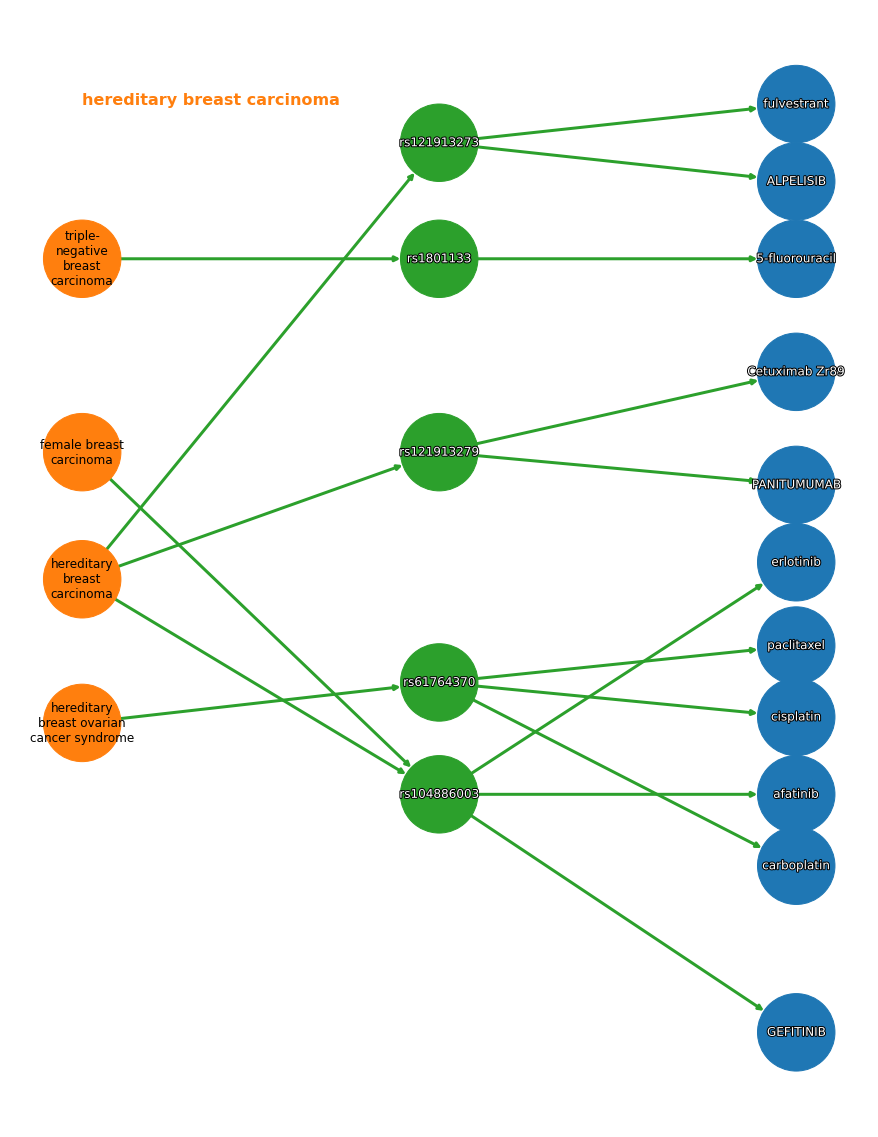

In [6]:
display_graph(df)

## Query Path: Disease -> Gene - (gene mutation affects drug response) > ChemicalSubstance

### Step 2: Find Chemicals of which the drug response is affected by genes related to Breast Cancer


Here, we formulate a `Predict` query with **breast cancer** as the `input_ojb`, **ChemicalSubstance** as the `output_obj` (which corresponds to a Biolink Entity type).  We further specify with the `intermediate_nodes` parameter that we are looking for paths joining hyperphenylalaninemia and chemical compounds with *one* intermediate node that is a Gene.

For the first step of the query (Disease - Gene), we specify to use a Normalized Google Distance (NGD) filter which only return associations with **NGD score less than 0.6**. 

For the second step of the query (Gene - Chemical), we specify to filter for association only under the **context of Breast Cancer** and limit the **predicate** to **gene_has_variant_that_contributes_to_drug_response**. 

Finally, we ask the results to be annotated with **drugPhase, nodeDegree and survivalProbability** information. 

In [4]:
query_config = {
    "filters": [
        {
            "ngd": {
                "<": 0.6
            }
        },
        {
            "disease_context": {
                "=": "MONDO:0006256"
            }
        }
    ],
    "predicates": [None, "gene_has_variant_that_contributes_to_drug_response_association"],
    "expand": True,
    "annotate": ["ngd", "drugPhase", "survivalProbability"]
}

In [5]:
pd = Predict(
    input_objs=[brca],
    intermediate_nodes =['Gene'], 
    output_types =['ChemicalSubstance'], 
    config=query_config
)
pd.connect(verbose=True)


========== QUERY EXPANSION ==========

You have selected to expand your inputs.
102 unique bioentities have been found as subclass of your inputs.

========== QUERY PARAMETER SUMMARY ==========

Your query have 103 input nodes, including breast cancer,breast lobular carcinoma,progesterone-receptor positive breast cancer,progesterone-receptor negative breast cancer,Her2-receptor negative breast cancer .... And BTE will find paths that connect your input nodes to your output types ['ChemicalSubstance']. Paths will contain 1 intermediate nodes.

Intermediate node #1 will have these type constraints: Gene

========== Query # 1 ==========

==== Step #1: Query Path Planning ====

Input Types: Disease
Output Types: Gene
Predicates: None

BTE found 12 APIs based on SmartAPI Meta-KG.

API 1. TCGA Mutation Frequency KP API (103 API calls)
API 2. Automat CORD19 Scigraph API (103 API calls)
API 3. mydisease.info API (1 API calls)
API 4. SEMMED Disease API (15 API calls)
API 5. MGIgene2phenotype A

### Step 3: Display and Filter results


In [6]:
df2 = pd.display_table_view(extra_fields=["drug_phase", "survival_prob_change", "ngd"])
df2

,input_id,input_label,input_type,pred1,pred1_source,pred1_api,pred1_publications,node1_id,node1_label,node1_type,...,pred2_source,pred2_api,pred2_publications,output_id,output_label,output_type,output_degree,pred2_drug_phase,pred2_survival_prob_change,pred2_ngd
0,MONDO:0007254,breast cancer,Disease,related_to,scigraph,Automat CORD19 Scigraph API,None,NCBIGene:5728,PTEN,Gene,...,Multiomics Provider,Drug Response KP API,None,CHEBI:91359,AZD-6482,ChemicalSubstance,13,1,NaN,NaN
1,MONDO:0007254,breast cancer,Disease,related_to,scigraph,Automat CORD19 Scigraph API,None,NCBIGene:5728,PTEN,Gene,...,Multiomics Provider,Drug Response KP API,None,CHEBI:91359,AZD-6482,ChemicalSubstance,13,1,NaN,NaN
2,MONDO:0007254,breast cancer,Disease,related_to,scigraph,Automat CORD19 Scigraph API,None,NCBIGene:5728,PTEN,Gene,...,Multiomics Provider,Drug Response KP API,None,CHEMBL.COMPOUND:CHEMBL3186774,PUBCHEM:54685215,ChemicalSubstance,5,0,NaN,NaN
3,MONDO:0007254,breast cancer,Disease,related_to,scigraph,Automat CORD19 Scigraph API,None,NCBIGene:5728,PTEN,Gene,...,Multiomics Provider,Drug Response KP API,None,CHEBI:82701,IDELALISIB,ChemicalSubstance,4,4,NaN,NaN
4,MONDO:0007254,breast cancer,Disease,related_to,scigraph,Automat CORD19 Scigraph API,None,NCBIGene:5728,PTEN,Gene,...,Multiomics Provider,Drug Response KP API,None,CHEMBL.COMPOUND:CHEMBL222102,KU-55933,ChemicalSubstance,3,0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2775,MONDO:0004989,breast carcinoma,Disease,related_to,gwascatalog,BioLink API,PMID:25117820,NCBIGene:84441,MAML2,Gene,...,Multiomics Provider,Drug Response KP API,None,CHEBI:27899,CISPLATIN,ChemicalSubstance,1,4,NaN,NaN
2776,MONDO:0004989,breast carcinoma,Disease,related_to,gwascatalog,BioLink API,PMID:25117820,NCBIGene:84441,MAML2,Gene,...,Multiomics Provider,Drug Response KP API,None,CHEBI:91353,CI-1040,ChemicalSubstance,4,2,NaN,NaN
2777,MONDO:0004989,breast carcinoma,Disease,related_to,gwascatalog,BioLink API,PMID:25117820,NCBIGene:84441,MAML2,Gene,...,Multiomics Provider,Drug Response KP API,None,CHEMBL.COMPOUND:CHEMBL62136,T091317,ChemicalSubstance,5,0,NaN,NaN
2778,MONDO:0004989,breast carcinoma,Disease,related_to,gwascatalog,BioLink API,PMID:25117820,NCBIGene:84441,MAML2,Gene,...,Multiomics Provider,Drug Response KP API,None,PUBCHEM:456190,PUBCHEM:456190,ChemicalSubstance,8,0,NaN,NaN


### Filtering and Ranking the results

#### Rank based on NGD provided by Text Mining Provider and DrugPhase

In [12]:
df_ngd = df2.sort_values(by=["pred1_ngd", "pred2_drug_phase"], ascending=[True, False])
df_ngd

,input_id,input_label,input_type,pred1,pred1_source,pred1_api,pred1_publications,node1_id,node1_label,node1_type,...,pred2_source,pred2_api,pred2_publications,output_id,output_label,output_type,output_degree,pred2_drug_phase,pred2_ngd,pred2_survival_prob_change
1022,MONDO:0016419,hereditary breast carcinoma,Disease,related_to,disgenet,mydisease.info API,None,NCBIGene:675,BRCA2,Gene,...,Multiomics Provider,Drug Response KP API,None,CHEBI:480999,VINORELBINE,ChemicalSubstance,5,4,NaN,NaN
1026,MONDO:0016419,hereditary breast carcinoma,Disease,related_to,disgenet,mydisease.info API,None,NCBIGene:675,BRCA2,Gene,...,Multiomics Provider,Drug Response KP API,None,CHEBI:27504,MITOMYCIN,ChemicalSubstance,5,4,0.425735,NaN
1031,MONDO:0016419,hereditary breast carcinoma,Disease,related_to,disgenet,mydisease.info API,None,NCBIGene:675,BRCA2,Gene,...,Multiomics Provider,Drug Response KP API,None,CHEMBL.COMPOUND:CHEMBL3137320,TALAZOPARIB,ChemicalSubstance,2,4,NaN,NaN
1033,MONDO:0016419,hereditary breast carcinoma,Disease,related_to,disgenet,mydisease.info API,None,NCBIGene:675,BRCA2,Gene,...,Multiomics Provider,Drug Response KP API,None,CHEBI:63452,MIDOSTAURIN,ChemicalSubstance,3,4,NaN,NaN
1035,MONDO:0016419,hereditary breast carcinoma,Disease,related_to,disgenet,mydisease.info API,None,NCBIGene:675,BRCA2,Gene,...,Multiomics Provider,Drug Response KP API,None,CHEBI:4911,ETOPOSIDE,ChemicalSubstance,4,4,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2705,MONDO:0004989,breast carcinoma,Disease,related_to,SEMMED,SEMMED Disease API,PMID:24979463,NCBIGene:8289,ARID1A,Gene,...,Multiomics Provider,Drug Response KP API,None,CHEBI:81068,SHIKONIN,ChemicalSubstance,4,0,NaN,NaN
2707,MONDO:0004989,breast carcinoma,Disease,related_to,SEMMED,SEMMED Disease API,PMID:24979463,NCBIGene:8289,ARID1A,Gene,...,Multiomics Provider,Drug Response KP API,None,PUBCHEM:456190,PUBCHEM:456190,ChemicalSubstance,8,0,NaN,NaN
2708,MONDO:0004989,breast carcinoma,Disease,related_to,SEMMED,SEMMED Disease API,PMID:24979463,NCBIGene:8289,ARID1A,Gene,...,Multiomics Provider,Drug Response KP API,None,PUBCHEM:5357795,PUBCHEM:5357795,ChemicalSubstance,4,0,NaN,NaN
2709,MONDO:0004989,breast carcinoma,Disease,related_to,SEMMED,SEMMED Disease API,PMID:24979463,NCBIGene:8289,ARID1A,Gene,...,Multiomics Provider,Drug Response KP API,None,CHEMBL.COMPOUND:CHEMBL399583,AUY922,ChemicalSubstance,5,0,NaN,NaN


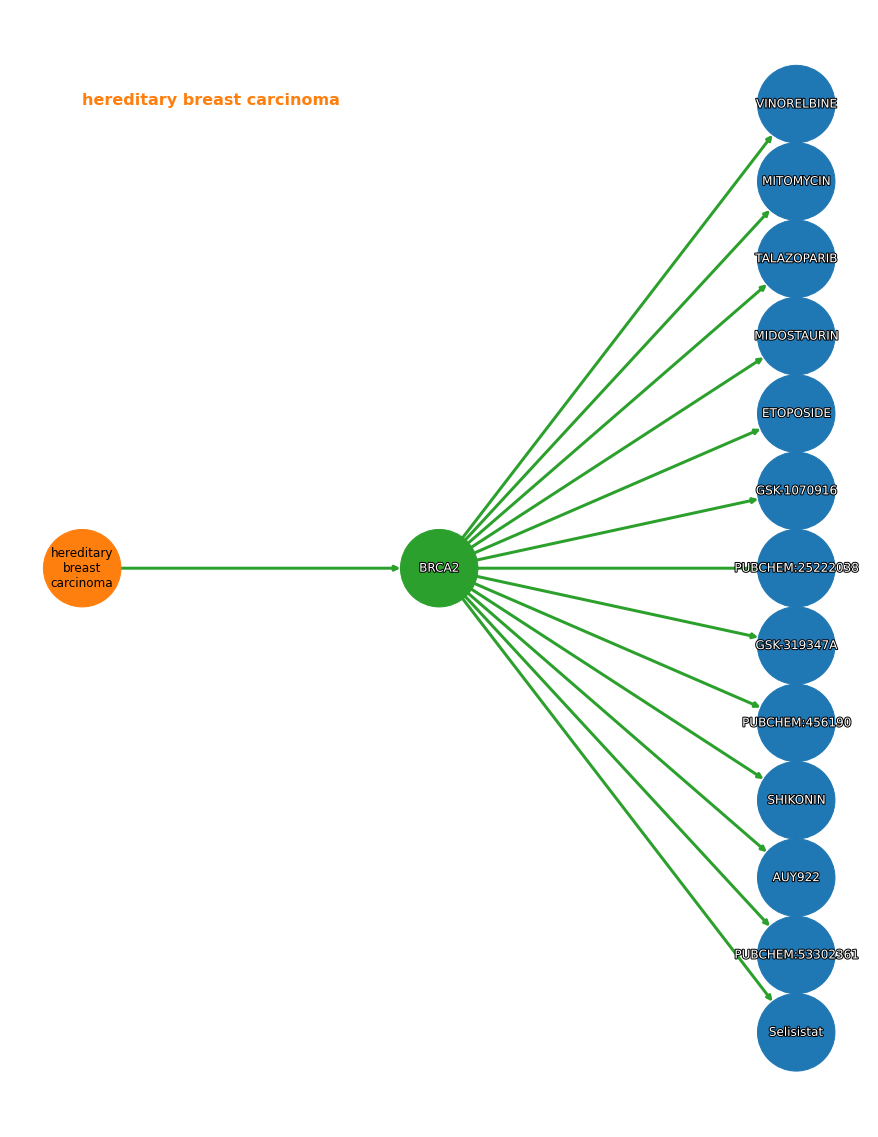

In [13]:
display_graph(df_ngd)

#### Rank by Survival Probability

In [8]:
df_negative_change_survival = df2.query("pred2_survival_prob_change < 0").sort_values(by="pred2_survival_prob_change")
df_negative_change_survival


,input_id,input_label,input_type,pred1,pred1_source,pred1_api,pred1_publications,node1_id,node1_label,node1_type,...,pred2_source,pred2_api,pred2_publications,output_id,output_label,output_type,output_degree,pred2_drug_phase,pred2_survival_prob_change,pred2_ngd
1974,MONDO:0004989,breast carcinoma,Disease,caused_by,SEMMED,SEMMED Disease API,PMID:7798298,NCBIGene:324,APC,Gene,...,Multiomics Provider,Drug Response KP API,None,CHEBI:480999,VINORELBINE,ChemicalSubstance,5,4,-4.000000,NaN
2130,MONDO:0007254,breast cancer,Disease,related_to,DISEASES,DISEASES API,None,NCBIGene:94025,MUC16,Gene,...,Multiomics Provider,Drug Response KP API,None,CHEBI:480999,VINORELBINE,ChemicalSubstance,5,4,-4.000000,NaN
2145,MONDO:0007254,breast cancer,Disease,related_to,DISEASES,DISEASES API,None,NCBIGene:94025,MUC16,Gene,...,Multiomics Provider,Drug Response KP API,None,CHEBI:480999,VINORELBINE,ChemicalSubstance,5,4,-4.000000,NaN
2160,MONDO:0007254,breast cancer,Disease,related_to,Translator Text Mining Provider,CORD Disease API,PMC:PMC6695468,NCBIGene:94025,MUC16,Gene,...,Multiomics Provider,Drug Response KP API,None,CHEBI:480999,VINORELBINE,ChemicalSubstance,5,4,-4.000000,NaN
1955,MONDO:0004989,breast carcinoma,Disease,affected_by,SEMMED,SEMMED Disease API,PMID:16901783,NCBIGene:3691,ITGB4,Gene,...,Multiomics Provider,Drug Response KP API,None,CHEBI:46345,FLUOROURACIL,ChemicalSubstance,8,4,-2.812500,NaN
2534,MONDO:0007254,breast cancer,Disease,related_to,Translator Text Mining Provider,CORD Disease API,"PMC:PMC6514155,PMC:PMC6617989",NCBIGene:23476,BRD4,Gene,...,Multiomics Provider,Drug Response KP API,None,CHEBI:46345,FLUOROURACIL,ChemicalSubstance,8,4,-2.812500,NaN
2416,MONDO:0007254,breast cancer,Disease,related_to,DISEASES,DISEASES API,None,NCBIGene:9732,DOCK4,Gene,...,Multiomics Provider,Drug Response KP API,None,CHEBI:46345,FLUOROURACIL,ChemicalSubstance,8,4,-2.812500,NaN
2759,MONDO:0004989,breast carcinoma,Disease,related_to,gwascatalog,BioLink API,"PMID:29059683,PMID:23535729,PMID:25751625",NCBIGene:54790,TET2,Gene,...,Multiomics Provider,Drug Response KP API,None,CHEBI:46345,FLUOROURACIL,ChemicalSubstance,8,4,-2.812500,NaN
2230,MONDO:0007254,breast cancer,Disease,related_to,DISEASES,DISEASES API,None,NCBIGene:2263,FGFR2,Gene,...,Multiomics Provider,Drug Response KP API,None,CHEBI:50681,METHOTREXATE,ChemicalSubstance,3,4,-2.750000,NaN
2241,MONDO:0007254,breast cancer,Disease,related_to,DISEASES,DISEASES API,None,NCBIGene:2263,FGFR2,Gene,...,Multiomics Provider,Drug Response KP API,None,CHEBI:50681,METHOTREXATE,ChemicalSubstance,3,4,-2.750000,NaN


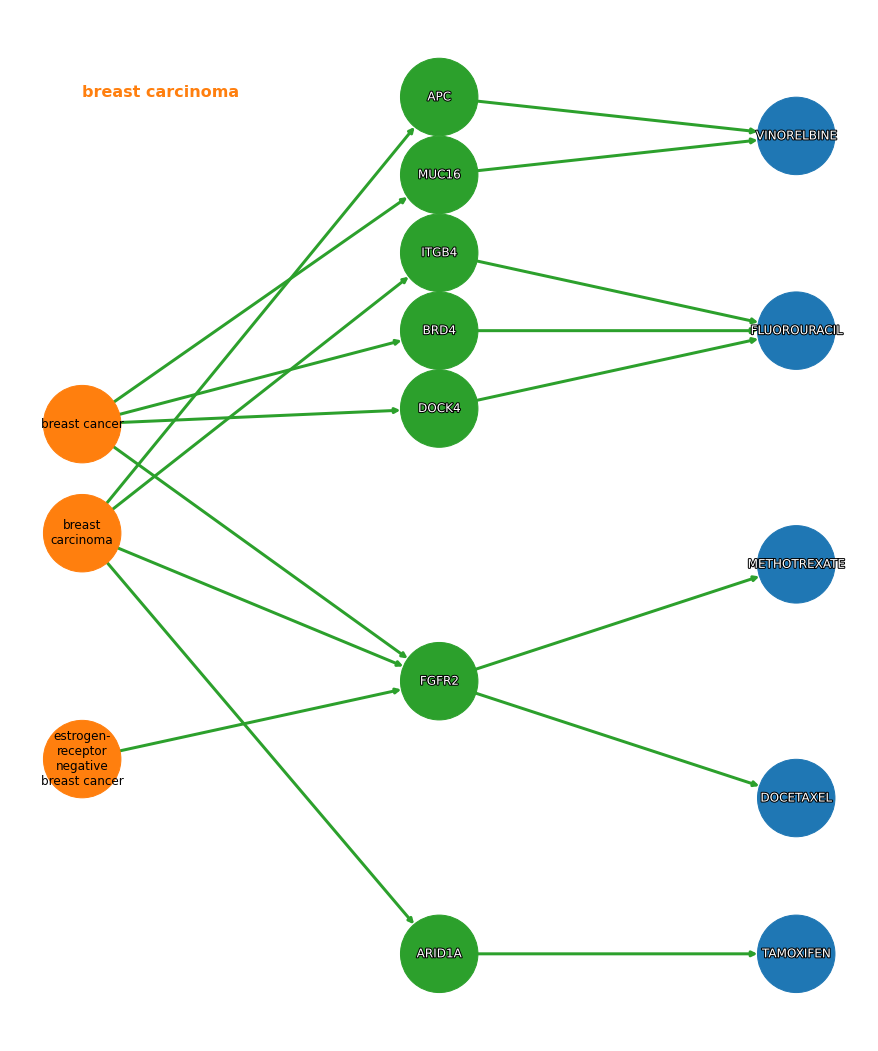

In [9]:
display_graph(df_negative_change_survival)

In [10]:
df_positive_change_survival = df2.query("pred2_survival_prob_change > 0").sort_values(by="pred2_survival_prob_change", ascending=False)
df_positive_change_survival

,input_id,input_label,input_type,pred1,pred1_source,pred1_api,pred1_publications,node1_id,node1_label,node1_type,...,pred2_source,pred2_api,pred2_publications,output_id,output_label,output_type,output_degree,pred2_drug_phase,pred2_survival_prob_change,pred2_ngd
2597,MONDO:0007254,breast cancer,Disease,related_to,Translator Text Mining Provider,CORD Disease API,PMC:PMC6535871,NCBIGene:26509,MYOF,Gene,...,Multiomics Provider,Drug Response KP API,None,CHEBI:46345,FLUOROURACIL,ChemicalSubstance,8,4,0.812500,NaN
2485,MONDO:0007254,breast cancer,Disease,related_to,DISEASES,DISEASES API,None,NCBIGene:8701,DNAH11,Gene,...,Multiomics Provider,Drug Response KP API,None,CHEBI:28748,DOXORUBICIN,ChemicalSubstance,2,4,0.580882,NaN
1593,MONDO:0005051,invasive lobular breast carcinoma,Disease,related_to,disgenet,mydisease.info API,None,NCBIGene:999,CDH1,Gene,...,Multiomics Provider,Drug Response KP API,None,CHEBI:46345,FLUOROURACIL,ChemicalSubstance,8,4,0.208333,0.568904
1929,MONDO:0016419,hereditary breast carcinoma,Disease,related_to,"omim,orphanet",BioLink API,None,NCBIGene:999,CDH1,Gene,...,Multiomics Provider,Drug Response KP API,None,CHEBI:46345,FLUOROURACIL,ChemicalSubstance,8,4,0.208333,0.568904
1905,MONDO:0016419,hereditary breast carcinoma,Disease,related_to,pharos,Automat PHAROS API,None,NCBIGene:999,CDH1,Gene,...,Multiomics Provider,Drug Response KP API,None,CHEBI:46345,FLUOROURACIL,ChemicalSubstance,8,4,0.208333,0.568904
1881,MONDO:0006256,invasive breast carcinoma,Disease,gene_has_variant_that_contributes_to_disease_a...,Multiomics Provider,TCGA Mutation Frequency KP API,None,NCBIGene:999,CDH1,Gene,...,Multiomics Provider,Drug Response KP API,None,CHEBI:46345,FLUOROURACIL,ChemicalSubstance,8,4,0.208333,0.568904
1857,MONDO:0005051,invasive lobular breast carcinoma,Disease,treated_by,SEMMED,SEMMED Disease API,PMID:25981591,NCBIGene:999,CDH1,Gene,...,Multiomics Provider,Drug Response KP API,None,CHEBI:46345,FLUOROURACIL,ChemicalSubstance,8,4,0.208333,0.568904
1833,MONDO:0005051,invasive lobular breast carcinoma,Disease,related_to,SEMMED,SEMMED Disease API,"PMID:11161777,PMID:11857408,PMID:25981591",NCBIGene:999,CDH1,Gene,...,Multiomics Provider,Drug Response KP API,None,CHEBI:46345,FLUOROURACIL,ChemicalSubstance,8,4,0.208333,0.568904
1809,MONDO:0006256,invasive breast carcinoma,Disease,related_to,SEMMED,SEMMED Disease API,PMID:20568901,NCBIGene:999,CDH1,Gene,...,Multiomics Provider,Drug Response KP API,None,CHEBI:46345,FLUOROURACIL,ChemicalSubstance,8,4,0.208333,0.568904
1569,MONDO:0005051,invasive lobular breast carcinoma,Disease,related_to,disgenet,mydisease.info API,None,NCBIGene:999,CDH1,Gene,...,Multiomics Provider,Drug Response KP API,None,CHEBI:46345,FLUOROURACIL,ChemicalSubstance,8,4,0.208333,0.568904


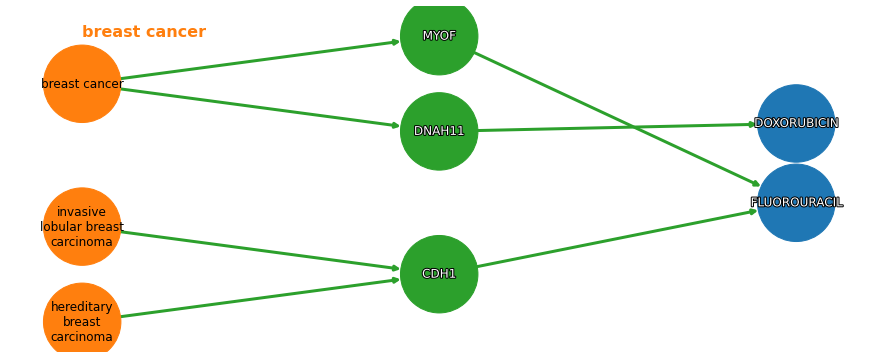

In [11]:
display_graph(df_positive_change_survival)